In [1]:
import os
import subprocess
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import utils as ut

data_dir = '../data/'
plot_dir = '../plots/'

## Learning of the 2d kite
- The aggregate state is the discretized attack angle (values specified in kite.h)
- The wind velocity is constant
- The initial angle with the ground, $\theta$, is constant
- The initial attack angle can be choosen constant or random
- The algortihm is a natural actor-critic with advantage parameters. It uses two power law learning rates (the one of the critic part should be much larger) having a burn-in period in which it stays constant (see the first plot of the learning rates)

In [104]:
system_name = 'kite2d'
run_name = 'nac2'

# ENVIRONMENT PARAMETERS
env_params = dict()
env_params['int_steps'] = 0.0005 # sec
env_params['ep_length'] = 50 # sec
env_params['decision_time'] = 0.01 # sec
env_params['init_theta'] = np.pi/4 # rad
env_params['init_dtheta'] = 0 # rad
env_params['init_alpha'] = 12 # rad. Choosing alpha>=15 the initial attack angle is randomly chosen
# wind
env_params['wind_type'] = 0 # Type 0 for a constant wind
env_params['v_wind_x'] = 15 # m/sec
env_params['v_wind_y'] = 0 # m/sec

# ALG PARAMETERS
alg_params = dict()
alg_params['gamma'] = 1.0
alg_params['n_steps'] = 5000000
print('Learning steps: ', alg_params['n_steps']*env_params['decision_time']/env_params['int_steps'])
print('Tot "real time" of learning, in seconds: ', alg_params['n_steps']*env_params['decision_time'])
alg_params['traj_points'] = 100
# <0 for false, >0 for true. The policy file must be in the folder
alg_params['use_init_pol_from_file'] = -1 
# <0 for false, >0 for true. The value file must be in the folder
alg_params['use_init_val_from_file'] = -1 
# Const init values (not used if previous element is 1)
alg_params['init_values'] = env_params['v_wind_x']*env_params['ep_length'] 
# Actor learning rate
alg_params['a0'] = 0.2
alg_params['ac'] = 3000
alg_params['a_expn'] = 0.8
alg_params['a_burn'] = 2000000
# Critic learning rate
alg_params['b0'] = 0.0002
alg_params['bc'] = 50000
alg_params['b_expn'] = 0.8
alg_params['b_burn'] = 4000000

Learning steps:  100000000.0
Tot "real time" of learning, in seconds:  50000.0


In [105]:
# WRITING THE PARAMETERS
try:
    os.mkdir(data_dir + system_name + '/' + run_name)
except OSError:
    print ("Creation of the directory failed")
    
f = open(data_dir + system_name + '/' + run_name + '/' + "param_env.txt", "w")
for k,v in env_params.items():
    f.write(k + "\t" + str(v) + "\n")
f.close()
    
f = open(data_dir + system_name + '/' + run_name + '/' + "param_alg.txt", "w")
for k,v in alg_params.items():
    f.write(k + "\t" + str(v) + "\n")
f.close()

Creation of the directory failed


In [106]:
# COMPILING C++ SCRIPT
comp_list = np.array(["g++", "-o", "train.exe", "train.cpp", "../lib/nac.cpp", "../lib/utils.cpp", "../lib/wind.cpp", 
            "../lib/envs/kite.cpp", "../lib/envs/"+system_name+".cpp", "-std=c++17"])
comp_str = ""
for s in comp_list: comp_str+=s+" "
print('To compile from terminal: ')
print(comp_str)
#p = subprocess.Popen(comp_str, stderr=subprocess.PIPE)
#print(p.stderr.read().decode('utf-8'))

To compile from terminal: 
g++ -o train.exe train.cpp ../lib/nac.cpp ../lib/utils.cpp ../lib/wind.cpp ../lib/envs/kite.cpp ../lib/envs/kite2d.cpp -std=c++17 


In [107]:
# EXECUTING THE SCRIPT
# Acually it doesn't print the standard output on-line. If you want the percentage execute from shell
#p = subprocess.Popen(["./train.exe", system_name, run_name], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
#print(p.stderr.read().decode('utf-8'))
#print(p.stdout.read().decode('utf-8'))

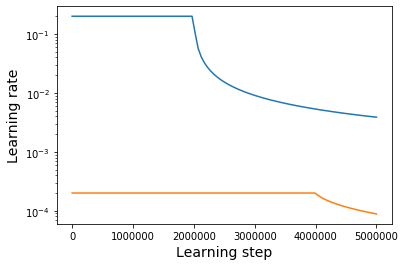

In [108]:
plt.xlabel('Learning step', fontsize=14)
plt.ylabel('Learning rate', fontsize=14)
plt.yscale('log')
xs = np.linspace(0, alg_params['n_steps'] , alg_params['traj_points'] )
crit_lr = [ut.p_law_burn(x, alg_params['a_burn'], alg_params['a_expn'], alg_params['a0'], alg_params['ac']) for x in xs]
act_lr = [ut.p_law_burn(x, alg_params['b_burn'], alg_params['b_expn'], alg_params['b0'], alg_params['bc']) for x in xs]

plt.plot(xs, crit_lr)
plt.plot(xs, act_lr)

#plt.savefig(plot_dir+ system_name + '/' + run_name + '/lr.png', dpi=200)

In [109]:
import numpy as np
#v_traj = np.loadtxt(data_dir + system_name + '/' + run_name + '/value_traj.txt', dtype='float')
v_traj, s_labels = ut.read_traj(data_dir + system_name + '/' + run_name + '/value_traj.txt')
r_traj = np.loadtxt(data_dir + system_name + '/' + run_name + '/return_traj.txt', dtype='float')

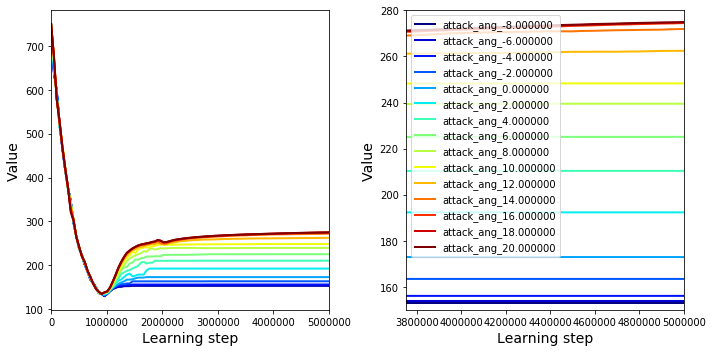

In [116]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
colors = plt.cm.jet(np.linspace(0,1,len(v_traj[0])))

ax1.set_xlabel('Learning step', fontsize=14)
ax1.set_ylabel('Value', fontsize=14)
ax1.set_xlim([0,alg_params['n_steps']])
#ax1.set_ylim([-100,alg_params['init_values']])
for k in range(0,len(v_traj[0])):
    ax1.plot(xs, v_traj[:,k], c=colors[k], label=s_labels[k], lw=2)


ax2.set_xlabel('Learning step', fontsize=14)
ax2.set_ylabel('Value', fontsize=14)
ax2.set_xlim([alg_params['n_steps']/4*3,alg_params['n_steps']])
ax2.set_ylim([150,280])
#ax1.set_ylim([-100,alg_params['init_values']])
for k in range(0,len(v_traj[0])):
    ax2.plot(xs, v_traj[:,k], c=colors[k], label=s_labels[k], lw=2)
ax2.legend(loc=2)

plt.tight_layout()
#plt.savefig(plot_dir+ system_name + '/' + run_name + '/values.png', dpi=200)

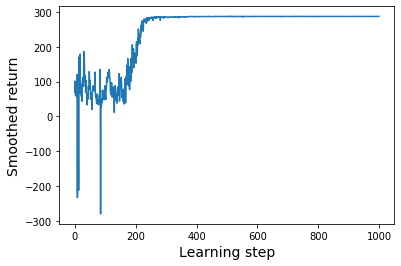

In [111]:
plt.xlabel('Learning step', fontsize=14)
plt.ylabel('Smoothed return', fontsize=14)
x, y = ut.smooth_traj(r_traj, 1)
plt.plot(x,y)

#plt.savefig(plot_dir+ system_name + '/' + run_name + '/return.png', dpi=200)

In [112]:
p_traj, s_labels, a_labels = ut.read_policy(data_dir + system_name + '/' + run_name + '/' + "policy_traj.txt")

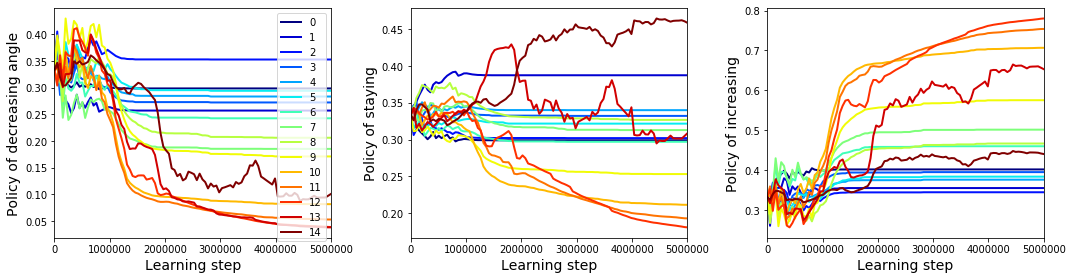

In [113]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,4))
colors = plt.cm.jet(np.linspace(0,1,len(v_traj[0])))
states = range(0,len(p_traj[0]))

ax1.set_xlabel('Learning step', fontsize=14)
ax1.set_ylabel('Policy of decreasing angle', fontsize=14)
xs = np.linspace(0, alg_params['n_steps'] , alg_params['traj_points'] )
ax1.set_xlim([0,alg_params['n_steps']])
#ax1.set_ylim([-100,alg_params['init_values']])
for k in states:
    ax1.plot(xs, p_traj[:,k,0], c=colors[k], label=str(k), lw=2)
ax1.legend()

ax2.set_xlabel('Learning step', fontsize=14)
ax2.set_ylabel('Policy of staying', fontsize=14)
ax2.set_xlim([0,alg_params['n_steps']])
#ax1.set_ylim([-100,alg_params['init_values']])
for k in states:
    ax2.plot(xs, p_traj[:,k,1], c=colors[k], label=str(k), lw=2)

ax3.set_xlabel('Learning step', fontsize=14)
ax3.set_ylabel('Policy of increasing', fontsize=14)
ax3.set_xlim([0,alg_params['n_steps']])
#ax1.set_ylim([-100,alg_params['init_values']])
for k in states:
    ax3.plot(xs, p_traj[:,k,2], c=colors[k], label=str(k), lw=2)
    
plt.tight_layout()
#plt.savefig(plot_dir+ system_name + '/' + run_name + '/policies.png', dpi=200)